In [1]:
from affinewarp import PiecewiseWarping
from affinewarp.metrics import warp_distances
from scipy.ndimage import gaussian_filter1d
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_data(params, noise="gaussian"):
    """Generates data and ground truth model."""
    
    # Create ground-truth model.
    model = PiecewiseWarping(n_knots=params['n_knots'])
    
    # Initialize warping knots.
    model.initialize_warps(params['n_trials'])
    model.x_knots, model.y_knots = model._mutate_knots(params['knot_mutation'])
    if params['clip_knots']:
        model.y_knots[:, 0] = 0.
        model.y_knots[:, -1] = 1.
    
    # Initialize template.
    template_shape = params['n_timepoints'], params['n_neurons']
    template = params['template_amplitude'] * np.random.rand(*template_shape)
    template = gaussian_filter1d(template, params['template_sigma'], axis=0)
    model.template = template
    
    # Generate data
    data = model.predict()
    if params['noise'] == 'poisson':
        data = np.random.poisson(data)
    elif params['noise'] == 'gaussian':
        data += params['noise_amplitude'] * np.random.randn(*data.shape)
    
    return data, model

In [3]:
data_params = {
    'n_trials': 120,
    'n_timepoints': 100,
    'n_neurons': 50,
    'clip_knots': True,
    'template_amplitude': 1.0,
    'template_sigma': 1.0,
    'noise': 'gaussian',
    'noise_amplitude': .1,
    'n_knots': 1,
    'knot_mutation': 0.1,
}
data, ground_truth = generate_data(data_params)

In [4]:
def rel_err(X, Xhat):
    return np.linalg.norm(X - Xhat) / np.linalg.norm(X)

In [5]:
def evaluate(model, ground_truth, n_replicates):
    warp_errors = []
    template_errors = []
    
    for i in range(n_replicates):
        # Fit model.
        model.fit(data, iterations=25, warp_iterations=40, verbose=False)

        # Evaluate warping error.
        warp_errors.append(warp_distances(model, ground_truth).mean())

        # Evaluate template error.
        template_errors.append(rel_err(data, model.predict()))
#         template_errors.append(rel_err(ground_truth.template, model.template))

    return warp_errors, template_errors, model.template

In [6]:
n_replicates = 5
max_knots = 4
warp_errors = np.empty((max_knots, n_replicates))
template_errors = np.empty((max_knots, n_replicates))
templates = np.empty([max_knots] + list(data.shape[1:]))

for n_knots in trange(max_knots):
    model = PiecewiseWarping(n_knots=n_knots, l2_reg_scale=0.0, max_temp=-1.,
                             smoothness_reg_scale=0.1, warp_reg_scale=0.0, n_restarts=1)
    warp_errors[n_knots], template_errors[n_knots], templates[n_knots] = evaluate(model, ground_truth, n_replicates)

100%|██████████| 4/4 [00:21<00:00,  5.29s/it]


In [7]:
from affinewarp.visualization import binned_heatmap

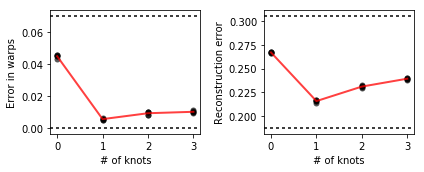

In [8]:
baseline = PiecewiseWarping(n_knots=data_params['n_knots'])
baseline.initialize_warps(data_params['n_trials'])
baseline.template = data.mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

axes[0].plot(warp_errors, '.k', ms=12, alpha=.65, mew=0)
axes[0].plot(warp_errors.mean(axis=1), '-r', alpha=.75, lw=2)
axes[0].axhline(warp_distances(ground_truth, baseline).mean(), color='k', dashes=[2,2])
axes[0].axhline(0, color='k', dashes=[2,2])
axes[0].set_xlabel('# of knots')
axes[0].set_ylabel('Error in warps')

axes[1].plot(template_errors, '.k', ms=12, alpha=.65, mew=0)
axes[1].plot(template_errors.mean(axis=1), '-r', alpha=.75, lw=2)
axes[1].axhline(rel_err(data, baseline.predict()), color='k', dashes=[2,2])
axes[1].axhline(rel_err(data, ground_truth.predict()), color='k', dashes=[2,2])
axes[1].set_xlabel('# of knots')
axes[1].set_ylabel('Reconstruction error')

fig.tight_layout()

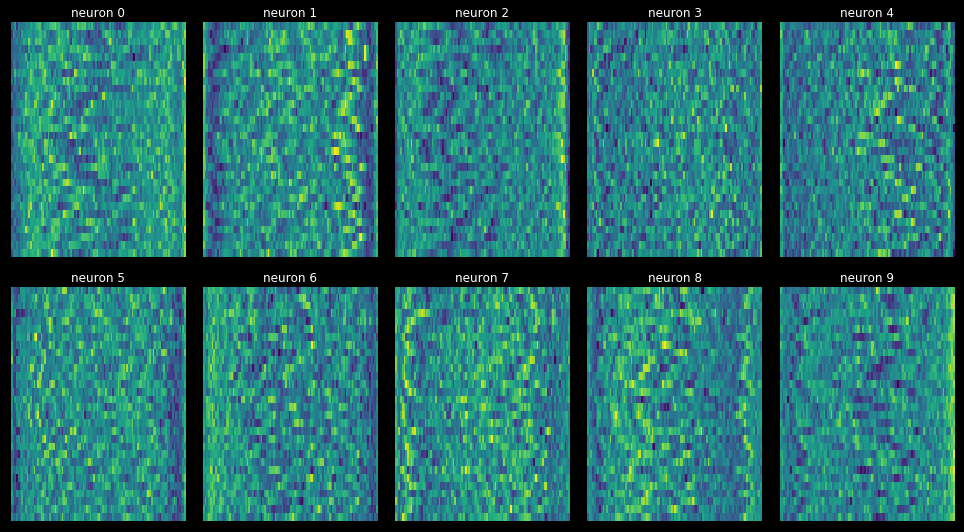

In [10]:
binned_heatmap(data[:30], subplots=(2,5));

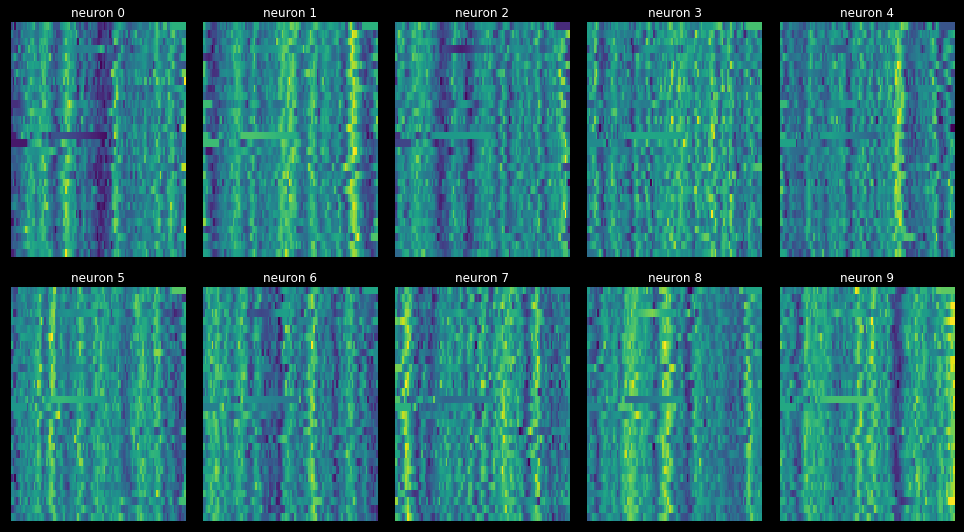

In [11]:
binned_heatmap(model.transform(data)[:30], subplots=(2,5));

## Evaluate loss as we move middle x-y knot

In [15]:
true_x_knots, true_y_knots = model.x_knots, model.y_knots

In [16]:
trial_losses = np.sum(np.abs(model_fit.predict()-data), (1,2))
worst_trial = np.argmax(trial_losses)

In [17]:
nx = 100
eps = 1e-9

learned_x, learned_y = model_fit.x_knots[worst_trial, 1], model_fit.y_knots[worst_trial, 1]

learned_x = 0.5
learned_y = 0.5
dx = 0.4
xx = np.linspace(learned_x-dx, learned_x+dx, nx)
yy = np.linspace(learned_y-dx, learned_y+dx, nx)
xs, ys = np.meshgrid(xx, yy)
model.loss_hist = []
model.warp_reg_scale = 0.0
model._initialize_storage(n_trials)
for x, y in zip(xs.ravel(), ys.ravel()):
    model.x_knots[worst_trial, 1] = x
    model.y_knots[worst_trial, 1] = y
    model._record_loss(data)

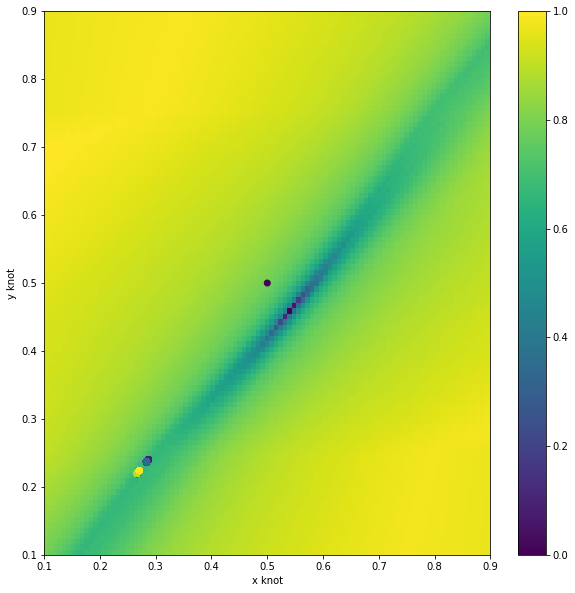

In [20]:
figure(figsize=(10,10))
losses = np.reshape(model.loss_hist, (nx, nx))
pcolor(xs, ys, np.log(losses));

knots = np.array(list(map(lambda xy: (xy[0][worst_trial, 1], xy[1][worst_trial, 1]), model_fit._knot_hist)))

c = np.linspace(0, 1, knots.shape[0])
scatter(knots[:, 0], knots[:, 1], c=c)
#plot(model_fit.x_knots[worst_trial, 1], model_fit.y_knots[worst_trial, 1], 'o', markersize=10)
xlabel('x knot')
ylabel('y knot')
colorbar()

model.

In [19]:
plot(model.x_knots.T - model.x, model.y_knots.T);

AttributeError: 'PiecewiseWarping' object has no attribute 'x'

In [ ]:
imshow(model_fit.template, aspect='auto')

In [ ]:
imshow(model.template, aspect='auto')